In [1]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Lux, MLUtils, Optimisers, Zygote, OneHotArrays, Random, Statistics, Printf, Reactant
using MLDatasets: MNIST
using SimpleChains: SimpleChains

Reactant.set_default_backend("cpu")

┌ Warning: Reactant_jll isn't availble for your platform Platform("x86_64", "windows"; libgfortran_version = "5.0.0", julia_version = "1.11.3", cuda_version = "none", gpu = "none", mode = "opt", cxxstring_abi = "cxx11")
└ @ Reactant C:\Users\corte\.julia\packages\Reactant\isN1H\src\Reactant.jl:275


ErrorException: could not load library ""
The parameter is incorrect. 

<span style="color:red">Advertencia esta es la primer escritura del código, no está optimizado en lo absoluto</span>

### ¿Qué es una función de activación? 

Permite a la red neuronal aproximar una función suave, la función de activación debe ser una transformación no lineal. 
La función de activación le dice a la red neuronal si debe activarse o no. (En LeakyRelu, vemos que si el valor es positivo, entonces $y = x$)

- La función de activación no se cambia durante el entrenamiento
- Es la misma función para todas las neuronas en una capa 
- y la función de activación puede cambiar de capa a capa. 

#### ¿Por qué debe de ser una transformación no lineal? 

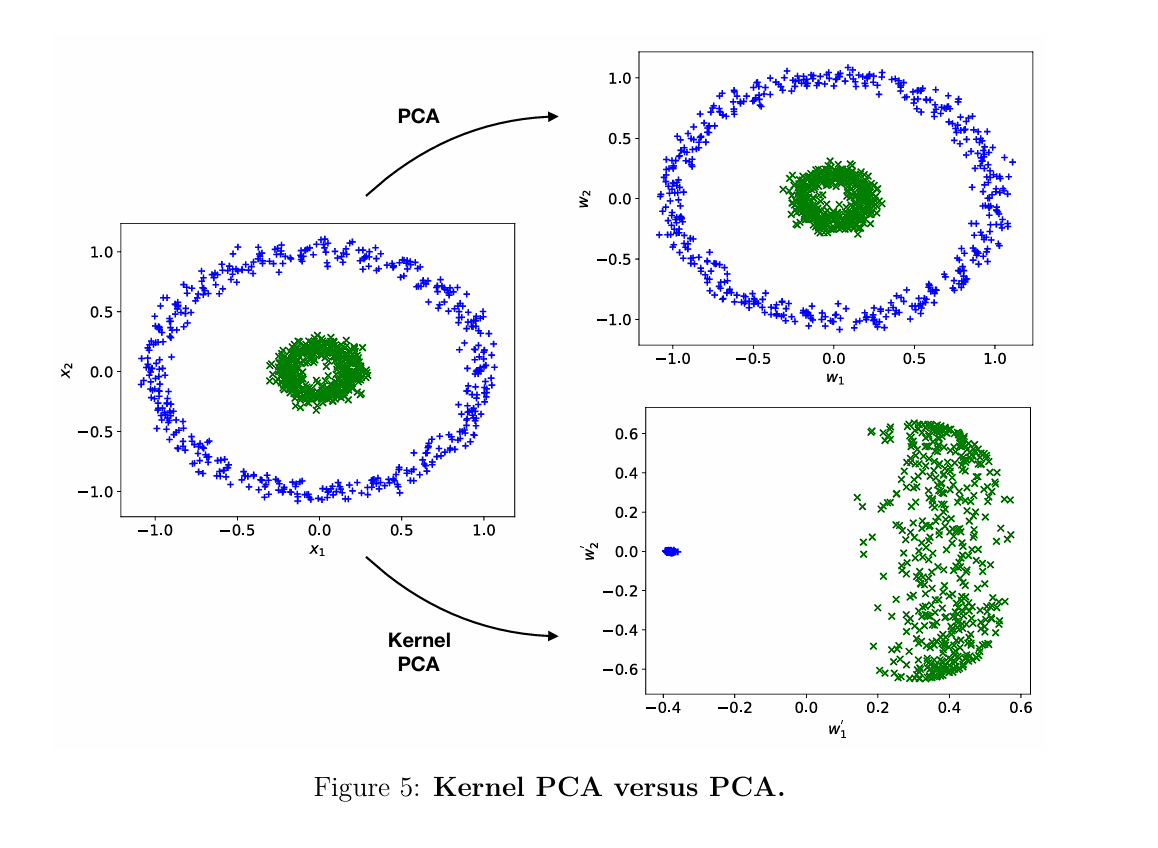

Este ejemplo es clave para entender que no todas las transformaciones pueden ser líneales para poder resolver el problema. 

PCA realiza sólo transformaciones lineales, lo que no provoca ningún cambio significativo en la información para este problema. 

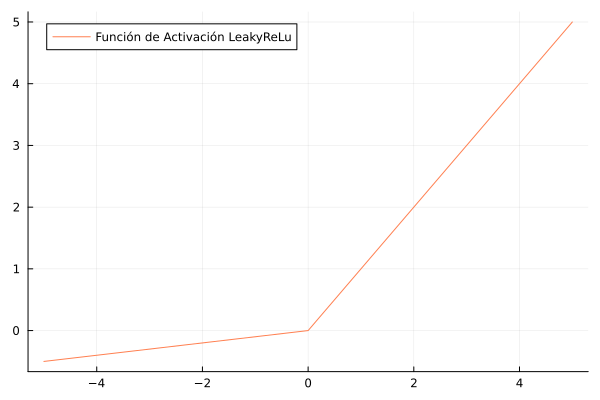

In [2]:
# La función de activación LeakyRelu se define como sigue 

function funcleakyrelu(x, α)
    if x > 0 
        return x 
    else 
        return α * x 
    end  
end
x = -5:0.1:5
y = funcleakyrelu.(x, 0.1)
plot(x,y, color = "coral", label = "Función de Activación LeakyReLu")

####  $ f(x) = \begin{cases} x &  \text{si }  x > 0 \\  \alpha x & \text{si } x \leq 0  \end{cases} $ 

### ¿Cuál es el problema que queremos resolver?

	Journal of Physics: Condensed Matter 33 (6), 064002 (2020)

    Es posible reconstruir un Hamiltoniano utilizando redes neuronales mediante el uso de operadores locales (calculando los valores esperados). 
    Se tomaron la primer mitad de vectores propios para calcular los valores esperados de $A_1$ y $A_2$  

Tenemos 3 qubits y queremos describirlos mediante dos operadores locales $A_1, A_2$ 

$A_1$ --> interactúa con el qubit 1 y 2 

$A_2$ --> interactúa con el qubit 2 y 3 

Se definen a los operadores locales como 

$A_1 = \sum_{i,j \in \{x,y,z\}} x_{i,j} \sigma_i \otimes \sigma_j \otimes \mathbb{I}   $

donde $\sigma_{i}$ son las matrices de Pauli, $x_{i,j}$ es un elemento de una distribución aleatoria uniforme entre $[-1,1] $. 

$A_2$ se define de forma análoga. 

## Generando los datos para nuestro sistema 

In [3]:
particles = 3
k=2
list=[0:3 for _ in 1:k]
test_visual_list = []
place= 2
for i in Base.product(list...)
    total_list=zeros(particles)
    total_list[place:place+k-1]= i|>collect
    if sum(total_list) != 0
        ##print(total_list)
        push!(test_visual_list,total_list)
    end
   # print("\n")
end
test_visual_list  #Generamos una lista de posibles configuraciones de interacción entre el 2do y 3er qubit (Para el operador local A2)
 

15-element Vector{Any}:
 [0.0, 1.0, 0.0]
 [0.0, 2.0, 0.0]
 [0.0, 3.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 1.0]
 [0.0, 2.0, 1.0]
 [0.0, 3.0, 1.0]
 [0.0, 0.0, 2.0]
 [0.0, 1.0, 2.0]
 [0.0, 2.0, 2.0]
 [0.0, 3.0, 2.0]
 [0.0, 0.0, 3.0]
 [0.0, 1.0, 3.0]
 [0.0, 2.0, 3.0]
 [0.0, 3.0, 3.0]

### Consideraciones iniciales de nuestro problema 

In [4]:
particles = 3 # number of qubits
d = 2^particles # dimension of the Hilbert space

# Matrices de Pauli, será nuestra base. 
sigmax = [0 1; 1 0]
sigmay = [0 -im; im 0]
sigmaz = [1 0; 0 -1]
id= [1 0; 0 1] # Matriz identidad

Sigma = Dict(0 => id, 1 => sigmax, 2 => sigmay, 3 => sigmaz) #Diccionario para llamar a las matrices de Pauli

Dict{Int64, Matrix} with 4 entries:
  0 => [1 0; 0 1]
  2 => Complex{Int64}[0+0im 0-1im; 0+1im 0+0im]
  3 => [1 0; 0 -1]
  1 => [0 1; 1 0]

In [5]:
k = 2 # Número de operadores locales que queremos generar

list=[0:3 for _ in 1:k] # Arreglo de tres secuencias de 0 a 3

2-element Vector{UnitRange{Int64}}:
 0:3
 0:3

In [6]:
# Generamos una lista de combinaciones de los operador local A1 
place = 1 # Se utiliza para considerar la interacción entre el primer y segundo qubit (Los elementos de A1) 
test_visual_list = []

for i in Base.product(list...)
    total_list=zeros(particles)
    total_list[place:place+k-1]= i|>collect
    if sum(total_list) != 0
        ##print(total_list)
        push!(test_visual_list,total_list)
    end
   # print("\n")
end

ArrayA1 = [] # Eliminamos las configuraciones que repetían un producto de matrices de Pauli, aunque en este momento, no sé si sea realmente necesario. Creo que recordar que esto salió porque teníamos degeneración, pero debe de existir degeneración porque estamos en un subespacio de Hilbert. 
for i in 1:length(test_visual_list)
    if test_visual_list[i][place] != test_visual_list[i][place+1] && sum(test_visual_list[i]) != 0
        push!(ArrayA1,test_visual_list[i])
    end
end

ArrayA1 

12-element Vector{Any}:
 [1.0, 0.0, 0.0]
 [2.0, 0.0, 0.0]
 [3.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [2.0, 1.0, 0.0]
 [3.0, 1.0, 0.0]
 [0.0, 2.0, 0.0]
 [1.0, 2.0, 0.0]
 [3.0, 2.0, 0.0]
 [0.0, 3.0, 0.0]
 [1.0, 3.0, 0.0]
 [2.0, 3.0, 0.0]

In [7]:
# Generamos una lista de combinaciones del operador local A2
place = 2 # Se utiliza para considerar la interacción entre el segundo y tercero qubit (Los elementos de A2)

test_visual_list = [] # Se tiene que volver a definir esta lista como una lista vacía 

for i in Base.product(list...)
    total_list=zeros(particles)
    total_list[place:place+k-1]= i|>collect
    if sum(total_list) != 0
        ##print(total_list)
        push!(test_visual_list,total_list)
    end
   # print("\n")
end

ArrayA2 = []
for i in 1:length(test_visual_list)
    if test_visual_list[i][place] != test_visual_list[i][place+1] && sum(test_visual_list[i]) != 0
        push!(ArrayA2,test_visual_list[i])
    end
end
ArrayA2

12-element Vector{Any}:
 [0.0, 1.0, 0.0]
 [0.0, 2.0, 0.0]
 [0.0, 3.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 2.0, 1.0]
 [0.0, 3.0, 1.0]
 [0.0, 0.0, 2.0]
 [0.0, 1.0, 2.0]
 [0.0, 3.0, 2.0]
 [0.0, 0.0, 3.0]
 [0.0, 1.0, 3.0]
 [0.0, 2.0, 3.0]

In [8]:
# En esta celda tenemos los operadores locales, podemos generar tantos como nos apetezca, pero realmente con generar 
# un sólo par de operadores locales, podemos considearar n pares de valores aleatorios para que existan n Hamiltonianos diferentes.


# Valores aleatorios. (1000 datos)
c = rand(2,1000)*2 .-1 # Estos son los valores de y, los que queremos predecir, cada columna es un valor de y (contiene dos elementos)

xaleatMat1 = rand(1000,length(ArrayA1)).*2 .-1 #Aquí realmente podríamos generar un operador A1 y A2 y sería suficiente. 
xaleatMat2 = rand(1000,length(ArrayA2)).*2 .-1


A1P_list = []  # Un arreglo vacío para almacenar matrices
A2P_list = []

for i in 1:1000
    A1P = zeros(2^particles, 2^particles)
    for k in 1:length(ArrayA1)
        A1P += xaleatMat1[i, k] * kron([Sigma[ArrayA1[k][j]] for j in eachindex(ArrayA1[1])]...)
    end
    push!(A1P_list, A1P)  # Guardar la matriz en el arreglo
end

for i in 1:1000
    A2P = zeros(2^particles,2^particles)
    for k in 1:length(ArrayA2)
        A2P += xaleatMat2[i,k]*kron([Sigma[ArrayA2[k][i]] for i in eachindex(ArrayA2[1])]...)
    end
    push!(A2P_list, A2P)  # Guardar la matriz en el arreglo
end

A111 = A1P_list[1] 
A222 = A2P_list[1] # Es por ello que sólo utilizaremos A111 y A222, un sólo par de operadores locales. 

8×8 Matrix{ComplexF64}:
 -0.188077+0.0im       -0.407218+0.670351im  …        0.0+0.0im
 -0.407218-0.670351im   0.815286+0.0im                0.0+0.0im
 -0.601002+1.32288im         0.0-0.772977im           0.0+0.0im
       0.0-0.941291im   -1.30023+0.342235im           0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.941291im
       0.0+0.0im             0.0+0.0im       …   -1.30023-0.342235im
       0.0+0.0im             0.0+0.0im          -0.234207-1.12697im
       0.0+0.0im             0.0+0.0im           0.188077+0.0im

En la próxima celda queremos generar un vector de tuplas $(x,y)$

Que serán los pares de datos que entrenará a nuestro modelo: 

$x$ es un vector que contiene los promedios $a_1^{n}$ y $a_2^{n}$ 

$a_1^{n} = \bra{\psi_n} A_1 \ket{\psi_n} \hspace{0.5cm}   $  y $  \hspace{0.5cm}  a_2^{n} = \bra{\psi_n} A_2 \ket{\psi_n} $

$y$ es un vector que contiene los valores aleatorios del Hamiltoniano $c_1$ y $c_2$, recordemos que 

$H = c_1 A_1 + c_2 A_2$

Sí tenemos $1000$ datos, queremos almacenarlo en un vector con dimensión $2 \times 1000$ [tuplas $(x,y)$] para poder trabajarlo de forma cómoda con la red neuronal 

In [ ]:
# En esta celda lo que haremos es generar un vector de tuplas con la información (x,y) donde x es un vector   
# que contiene los promedios a1 y a2 con el estado 0,1,2,... después el vector y tendrá los valores c1 y c2 
# estos valores se repetirán para todos los estados y promedios que consideramos del mismo Hamiltoniano, 
# es decir, si tenemos 4 estados y 2 promedio por estado, se repetirán 4 veces lso valores de y: c1 y c2
# Tomamos para x la mitad de los estados del sistema

n = 1000 # Número de datos que queremos generar 

# Inicializamos un vector vacío para almacenar las 1000 tuplas 
Tup = []

for k in 1 : n

    mat1a1 = zeros(2) # Colocamos un vector de ceros que se va a reiniciar en cada paso 

    # Formamos el Hamiltoniano
    H12 = c[1,k]*A111 + c[2,k]*A222

    # Tomamos los vectores propios 

    vor  = eigen(H12).vectors
    adjvor = adjoint(vor)

    vor[:,1] # Este es el primer vector propio, los vectores propios con eigen se colocan en columnas 
    adjvor[1,:] # Este es el primer vector propio para la adjunta (Recordemos es un vector izquierdo [Fila])

    # Calculamos el valor esperado de la primera mitad de vectores propios

    ExpValA = zeros(ComplexF64, Int((size(vor)[1])/2))
    for i in 1:Int((size(vor)[1])/2)
        ExpValA[i] = transpose(adjvor[i,:])*A111*vor[:,i]
    end

    ExpValB = zeros(ComplexF64,Int((size(vor)[1])/2))  # ExpVal2[1] = a21 = \bra{\phi1_}A_2\ket{\phi_1}
    for i in 1:Int((size(vor)[1])/2)
        ExpValB[i] = transpose(adjvor[i,:])*A222*vor[:,i]
    end

    ValsA = real(ExpValA) # Nos interesa únicamente la parte real, la parte imaginaria suele ser error 
    ValsB = real(ExpValB)
    mat1a1[1] = ValsA[1]
    mat1a1[2] = ValsB[1]

    tk = (mat1a1, c[:,k]) # Generamos una tupla con un vector que tiene 2 promedios y un vector con c1 y c2 para el respectivo Hamiltoniano
    push!(Tup,tk) # Agregar la tupla al vector 

    ValsCompleto = vcat(ValsA, ValsB) # Por último nuestro vector tendrá la forma de 8x1, para poder agregarlo al batch 
end 

In [11]:
Tup[1][1]

2-element Vector{Float64}:
 -3.7351245663420487
 -2.2555457603994364

Una vez procesados los datos de la forma correcta, la función loadata dividirá en mini batches los datos y además tomará un porcentaje de los datos para que sean entrenamiento y el resto serán utilizados para testear el entrenamiento  

In [ ]:
function loadata(batchsize, train_split)
    # Separar la tupla anterior en los dos batches de datos, los elementos de x y los de y. 

    # Extract inputs (x) and outputs (y) from the tuples
    x_batch = cat(map(t -> t[1], Tup)...; dims=2) 
    y_batch = cat(map(t -> t[2], Tup)...; dims=2)  # Stack outputs along the 2nd dimension (batch)
    (x_train, y_train), (x_test, y_test) = splitobs((x_batch, y_batch); at=train_split) # Separa los datos en train y test

    return (
        # Use DataLoader to automatically minibatch and shuffle the data
        DataLoader(collect.((x_train, y_train)); batchsize, shuffle=true, partial=false),
        # Don't shuffle the test data
        DataLoader(collect.((x_test, y_test)); batchsize, shuffle=false, partial=false),
    )
end

# batchsize será el tamaño del subconjunto de datos
# train_split, en decimal, el porcentaje de datos que se utilizarán para entrenamiento, el complemento será para test. 

loadata (generic function with 1 method)

Se define la arquitectura del modelo:

Dos redes neuronales una de 64 neuronas y otra de 32 neuronas, además de una capa oculta con la función de activación "myleakyrelu" 

In [13]:
myleakyrelu(x) = leakyrelu(x,0.1)

model = Chain(
    Dense(2,64),
    Dense(64,32,myleakyrelu),
    Dense(32,2)
)

Chain(
    layer_1 = Dense(2 => 64),           # 192 parameters
    layer_2 = Dense(64 => 32, myleakyrelu),  # 2_080 parameters
    layer_3 = Dense(32 => 2),           # 66 parameters
)         # Total: 2_338 parameters,
          #        plus 0 states.

### Función de pérdida

Es una función que nos calcula que tan cercanos estamos entre los valores de $y$ y los valores predichos por el modelo.
#### Nuestro objetivo es minimizar la función de pérdida.

In [1]:
# Función de pérdida

CosineSimilarity(x,y) = sum(x.*y)/sqrt(sum(x.^2)*sum(y.^2)) # x, y no son los mismos que los del modelo
function myloss(x,y)
    return 1 - CosineSimilarity(x,y)
end

function loss_fn(model,ps,st,d)
    x,y = d
    ŷ,stn = model(x,ps,st)

    return myloss(ŷ,y),stn,(;)
end

loss_fn (generic function with 1 method)

### Adaptando el modelo a simple chains

In [18]:
adaptor = ToSimpleChainsAdaptor((2,))  # forma de entrada
simple_chains_model = adaptor(model)

SimpleChainsLayer(
    Chain(
        layer_1 = Dense(2 => 64),       # 192 parameters
        layer_2 = Dense(64 => 32, myleakyrelu),  # 2_080 parameters
        layer_3 = Dense(32 => 2),       # 66 parameters
    ),
)         # Total: 2_338 parameters,
          #        plus 0 states.

In [19]:
 const lossfn = loss_fn
# const lossfn = CrossEntropyLoss(; logits=Val(true)) # const se usa para decirle a Julia que el tipo de la variable global no va a cambiar: https://docs.julialang.org/en/v1/base/base/#const
function accuracy(model, ps, st, dataloader)
    total_correct, total = 0, 0
    st = Lux.testmode(st) # Se configura el modelo para hacer inferencia.
    for (x, y) in dataloader
        target_class = onecold(Array(y)) # Es tomar el elemento con mayor probabilidad. Equivalentemente es softmax con temperature cero.
        predicted_class = onecold(Array(first(model(x, ps, st)))) # Es tomar el elemento con mayor probabilidad. Equivalentemente es softmax con temperature cero.
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct / total
end

accuracy (generic function with 1 method)

### Función para entrenar

Adam (Adaptive Moment Estimation) es un algoritmo de optimización que permite encontrar mínimos más adecuados en la función de pérdida. 

En general es imposible encontrar el mínimo absoluto, por lo que es conveniente conformarse con un mínimo "adecuado".

In [ ]:
fieldnames(Adam) 

(:eta, :beta, :epsilon)

In [21]:
function train(model, dev=cpu_device(); rng=Random.default_rng(), kwargs...)
    train_dataloader, test_dataloader = dev(loadata(100, 0.9))
    ps, st = dev(Lux.setup(rng, model)) # se inicializan los parámetros del modelo de forma aleatoria y se cargan en el CPU (dev)

    vjp = dev isa ReactantDevice ? AutoEnzyme() : AutoZygote() # Usando Reactant permite compilar el modelo antes de entrenarlo: https://lux.csail.mit.edu/stable/manual/compiling_lux_models#reactant-compilation

    train_state = Training.TrainState(model, ps, st, Adam(3.0f-4)) 

    if dev isa ReactantDevice
        x_ra = first(test_dataloader)[1]
        model_compiled = @compile model(x_ra, ps, Lux.testmode(st)) # Justo aquí es compilado el modelo
    else
        model_compiled = model
    end

    ### Lets train the model
    nepochs = 10 # Cuantas veces se pasa por todos los datos
    tr_acc, te_acc = 0.0, 0.0 # Se inicializan las variables de accuracy
    for epoch in 1:nepochs
        stime = time()
        for (x, y) in train_dataloader # Dos preguntas: x y y ya son arreglos o son otro objeto? y en cada evaluación se reordenan?
            _, _, _, train_state = Training.single_train_step!(
                vjp, lossfn, (x, y), train_state
            )
        end
        ttime = time() - stime

        tr_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, train_dataloader
            ) * 100
        te_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, test_dataloader
            ) * 100

        @printf "[%2d/%2d] \t Time %.2fs \t Training Accuracy: %.2f%% \t Test Accuracy: \
                 %.2f%%\n" epoch nepochs ttime tr_acc te_acc
    end

    return train_state.parameters, train_state.states, tr_acc, te_acc # En el código del tutorial no están las primeras dos variables, lo modifiqué para que nos devuelva los parámetros entrenados.
end

train (generic function with 2 methods)

In [22]:
tr_acc, te_acc = train(model, reactant_device()); # entrenando el modelo en lux

[ 1/10] 	 Time 83.61s 	 Training Accuracy: 41.44% 	 Test Accuracy: 41.00%
[ 2/10] 	 Time 0.00s 	 Training Accuracy: 44.78% 	 Test Accuracy: 43.00%
[ 3/10] 	 Time 0.00s 	 Training Accuracy: 47.56% 	 Test Accuracy: 49.00%
[ 4/10] 	 Time 0.00s 	 Training Accuracy: 53.33% 	 Test Accuracy: 54.00%
[ 5/10] 	 Time 0.00s 	 Training Accuracy: 52.00% 	 Test Accuracy: 58.00%
[ 6/10] 	 Time 0.00s 	 Training Accuracy: 76.00% 	 Test Accuracy: 83.00%
[ 7/10] 	 Time 0.00s 	 Training Accuracy: 76.22% 	 Test Accuracy: 84.00%
[ 8/10] 	 Time 0.00s 	 Training Accuracy: 79.11% 	 Test Accuracy: 88.00%
[ 9/10] 	 Time 0.00s 	 Training Accuracy: 86.56% 	 Test Accuracy: 98.00%
[10/10] 	 Time 0.00s 	 Training Accuracy: 92.78% 	 Test Accuracy: 99.00%


In [23]:
ps, st, tr_acc, te_acc = train(simple_chains_model); #entrenando el modelo de simple simple_chains_model

[ 1/10] 	 Time 31.02s 	 Training Accuracy: 77.78% 	 Test Accuracy: 83.00%
[ 2/10] 	 Time 0.00s 	 Training Accuracy: 78.67% 	 Test Accuracy: 83.00%
[ 3/10] 	 Time 0.00s 	 Training Accuracy: 79.22% 	 Test Accuracy: 85.00%
[ 4/10] 	 Time 0.00s 	 Training Accuracy: 80.89% 	 Test Accuracy: 91.00%
[ 5/10] 	 Time 0.00s 	 Training Accuracy: 78.56% 	 Test Accuracy: 88.00%
[ 6/10] 	 Time 0.00s 	 Training Accuracy: 82.22% 	 Test Accuracy: 91.00%
[ 7/10] 	 Time 0.00s 	 Training Accuracy: 91.33% 	 Test Accuracy: 99.00%
[ 8/10] 	 Time 0.00s 	 Training Accuracy: 92.22% 	 Test Accuracy: 96.00%
[ 9/10] 	 Time 0.00s 	 Training Accuracy: 92.89% 	 Test Accuracy: 97.00%
[10/10] 	 Time 0.00s 	 Training Accuracy: 95.22% 	 Test Accuracy: 98.00%


### Es natural preguntarse, ¿qué tanto podemos reducir la cantidad de estados utilizados para entrenar el modelo y seguir obteniendo un resultado bueno?

Debido a que en el laboratorio siempre será más sencillo preparar estados menos excitados. 

En este caso, sólo he trabajado con el primer estado, y obtuve en los entrenamientos pasados una precisión de entrenamiento 

del $92.78\%$ para la arquitectura escogida 

del $95.22 \%$ para simplechains 

y la precisión de prueba es del 99 y 98 por ciento respectivamente 

In [29]:
function loss_fn(model,ps,st,d)
    x,y = d
    ŷ,stn = model(x,ps,st)

    return myloss(ŷ,y),stn,(;)
end

loss_fn (generic function with 1 method)